In [10]:
# installing packages ----------------------------------------------------------------
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)

# color blind friendly color ------------------------------------------------------------
lightblue <- "#56B4E9"
lightorange <- "#E69F00"
lightgreen <- "#009E73"
lightyellow <- '#FFC20A'

set.seed(999)
options(repr.plot.width = 15, repr.plot.height = 10) 

# dataset read from the web ------------------------------------------------------------
diabetes <- read_csv('https://raw.githubusercontent.com/Kayleeli/STAT201-Group-23/main/data/diabetes.csv') 

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): pregnancies, glucose, bloodpressure, skinthickness, insulin, bmi, d...
lgl (1): outcome

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
# clean + wrangled the data into tidy format ------------------------------------------

    # because we only want to focus on the relationship between bmi + outcome, selecting only:
        # 1) bmi column : body mass index in kg/m^2
        # 2) outcome column : TRUE = diabetic , FALSE = Non-diabetic

diabetes <- diabetes %>%
    select(bmi, outcome)

    # splitting people into 2 groups based on "outcome" (TRUE (diabetic) vs FALSE (non-diabetic))

diabetic_group <- diabetes %>%
    filter(outcome=="TRUE") %>%
    select(bmi)

nondiabetic_group <- diabetes %>%
    filter(outcome=="FALSE") %>%
    select(bmi)

In [12]:
# SAMPLE PARAMETERS

    # mean bmi values for people who are diabetic in this dataset
    diabetic_group_mean <- diabetic_group %>%
        summarize(mean = mean(bmi)) %>%
        pull()

    # mean bmi values for people who are non-diabetic in this dataset
    nondiabetic_group_mean <- nondiabetic_group %>%
        summarize(mean = mean(bmi)) %>%
        pull()

    # difference in mean bmi value for people with and without diabetes in this dataset
    difference_in_mean_pop <- diabetic_group_mean - nondiabetic_group_mean

    # summary of the population parameter calcuated above into a dataframe
    pop_parameter_summary <- matrix(c(diabetic_group_mean, nondiabetic_group_mean, difference_in_mean_pop), ncol = 3, byrow = TRUE) 
    colnames(pop_parameter_summary) <- c("Sample BMI Mean Value (Diabetic)", "Sample BMI Mean Value (Non-Diabetic)", "Difference in BMI Mean Value in Sample ((Diabetic)-(Non-Diabetic))")
    rownames(pop_parameter_summary) <- c('Values (in kg/m^2)')
    table_pop_parameter_summary <- as.data.frame(pop_parameter_summary)


# SAMPLE PARAMETER VALUES (SUMMARY)
table_pop_parameter_summary

,Sample BMI Mean Value (Diabetic),Sample BMI Mean Value (Non-Diabetic),Difference in BMI Mean Value in Sample ((Diabetic)-(Non-Diabetic))
,<dbl>,<dbl>,<dbl>
Values (in kg/m^2),35.14254,30.3042,4.838337


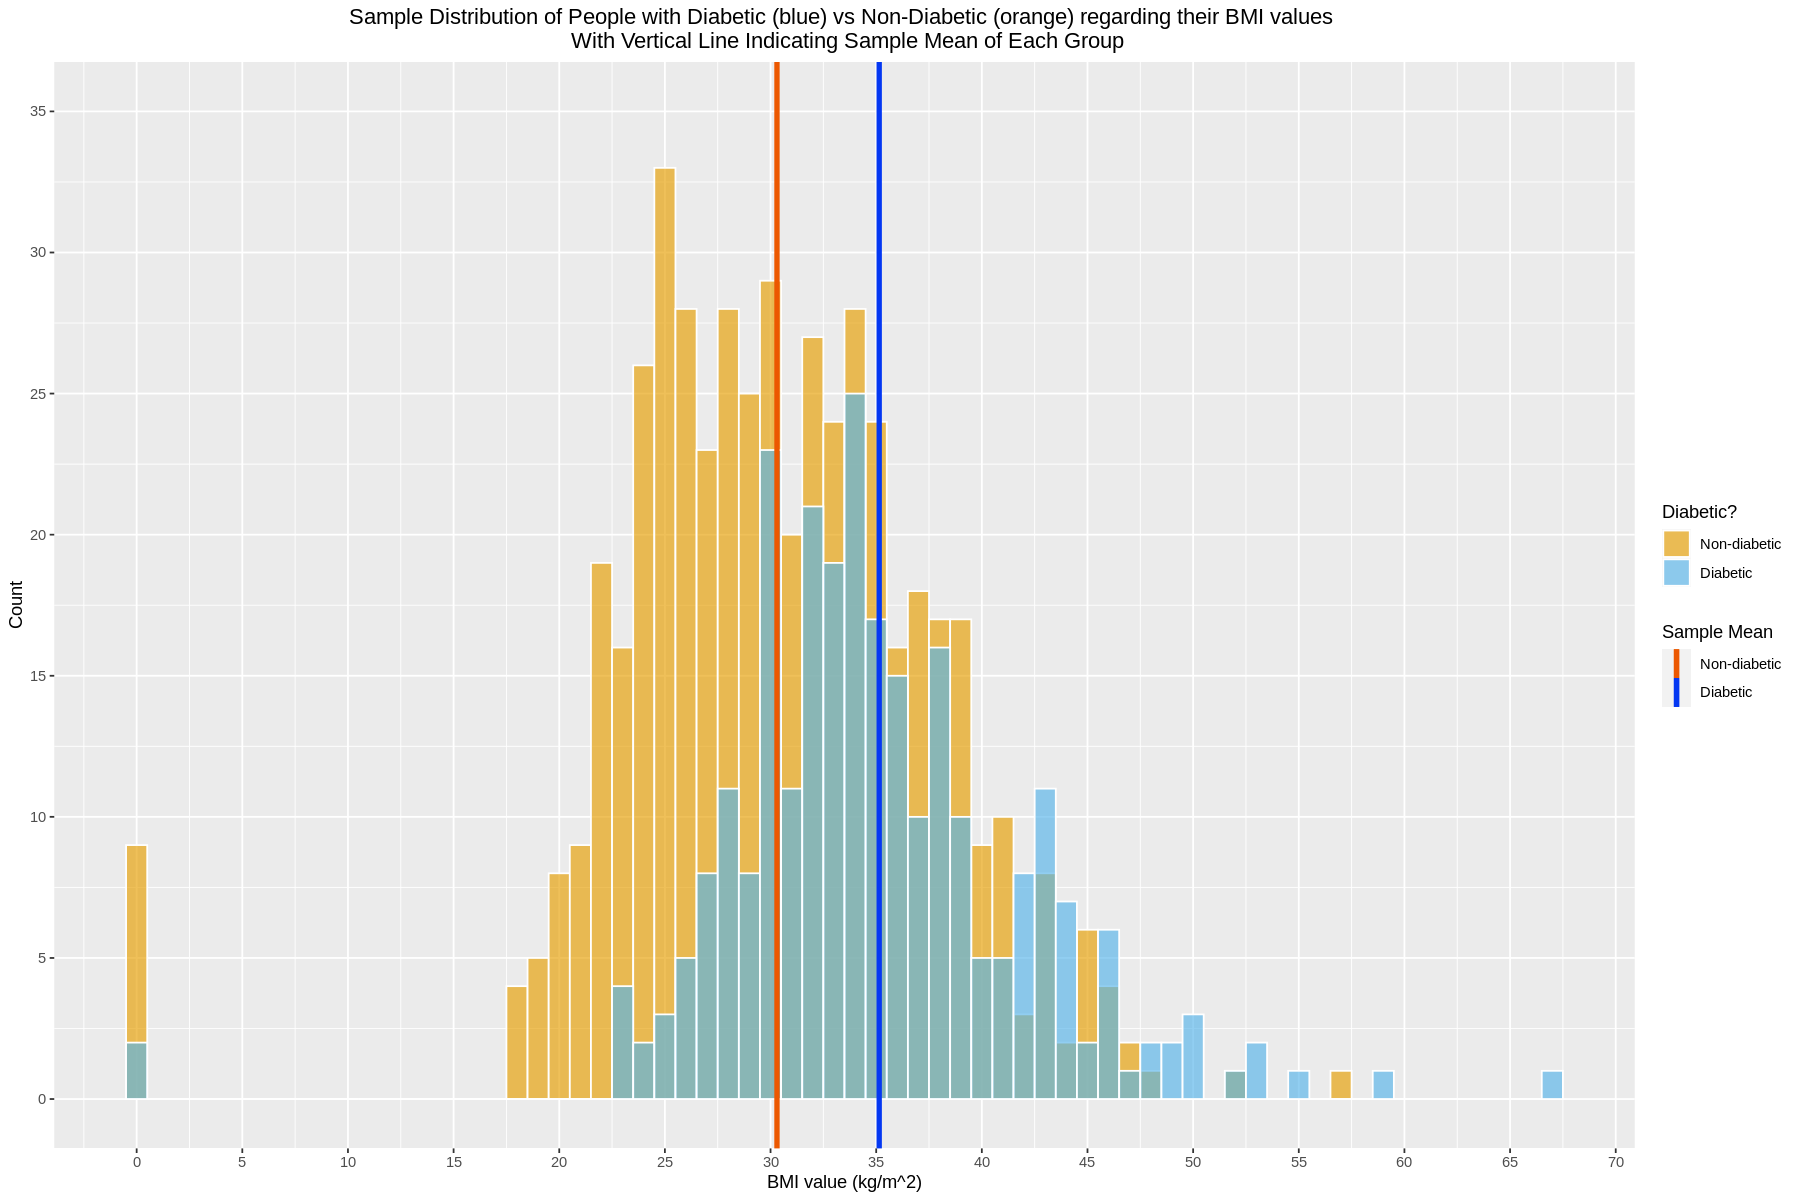

In [16]:
# HISTOGRAM : SAMPLE DISTRIBUTION [Diabetic vs Non-Diabetic, with vertical line indicating the mean of each group]

diabetic_and_nondiabetic_sample_hist <-
    diabetes %>%
    ggplot(aes(x = bmi, fill = outcome)) +
    geom_histogram(position = "identity", alpha = 0.65, binwidth = 1, color = 'white') +
    labs(x="BMI value (kg/m^2)", y = 'Count', title = 'Sample Distribution of People with Diabetic (blue) vs Non-Diabetic (orange) regarding their BMI values \n With Vertical Line Indicating Sample Mean of Each Group') +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_vline(aes(xintercept = nondiabetic_group_mean, color = 'nondiabetic_group_mean'), size = 1.5) +
    geom_vline(aes(xintercept = diabetic_group_mean, color = 'diabetic_group_mean'), size = 1.5) +
    scale_fill_manual(values = c(lightorange, lightblue), labels = c("Non-diabetic", "Diabetic"), name = 'Diabetic?') +
    scale_color_manual(values = c('nondiabetic_group_mean' = '#EC5800', 'diabetic_group_mean' = '#0437F2'), labels = c("Non-diabetic", "Diabetic"), name = 'Sample Mean') +
    scale_x_continuous(breaks=seq(0,70, 5)) +
    scale_y_continuous(limits = c(0, 35), breaks=seq(0,35, 5))

diabetic_and_nondiabetic_sample_hist

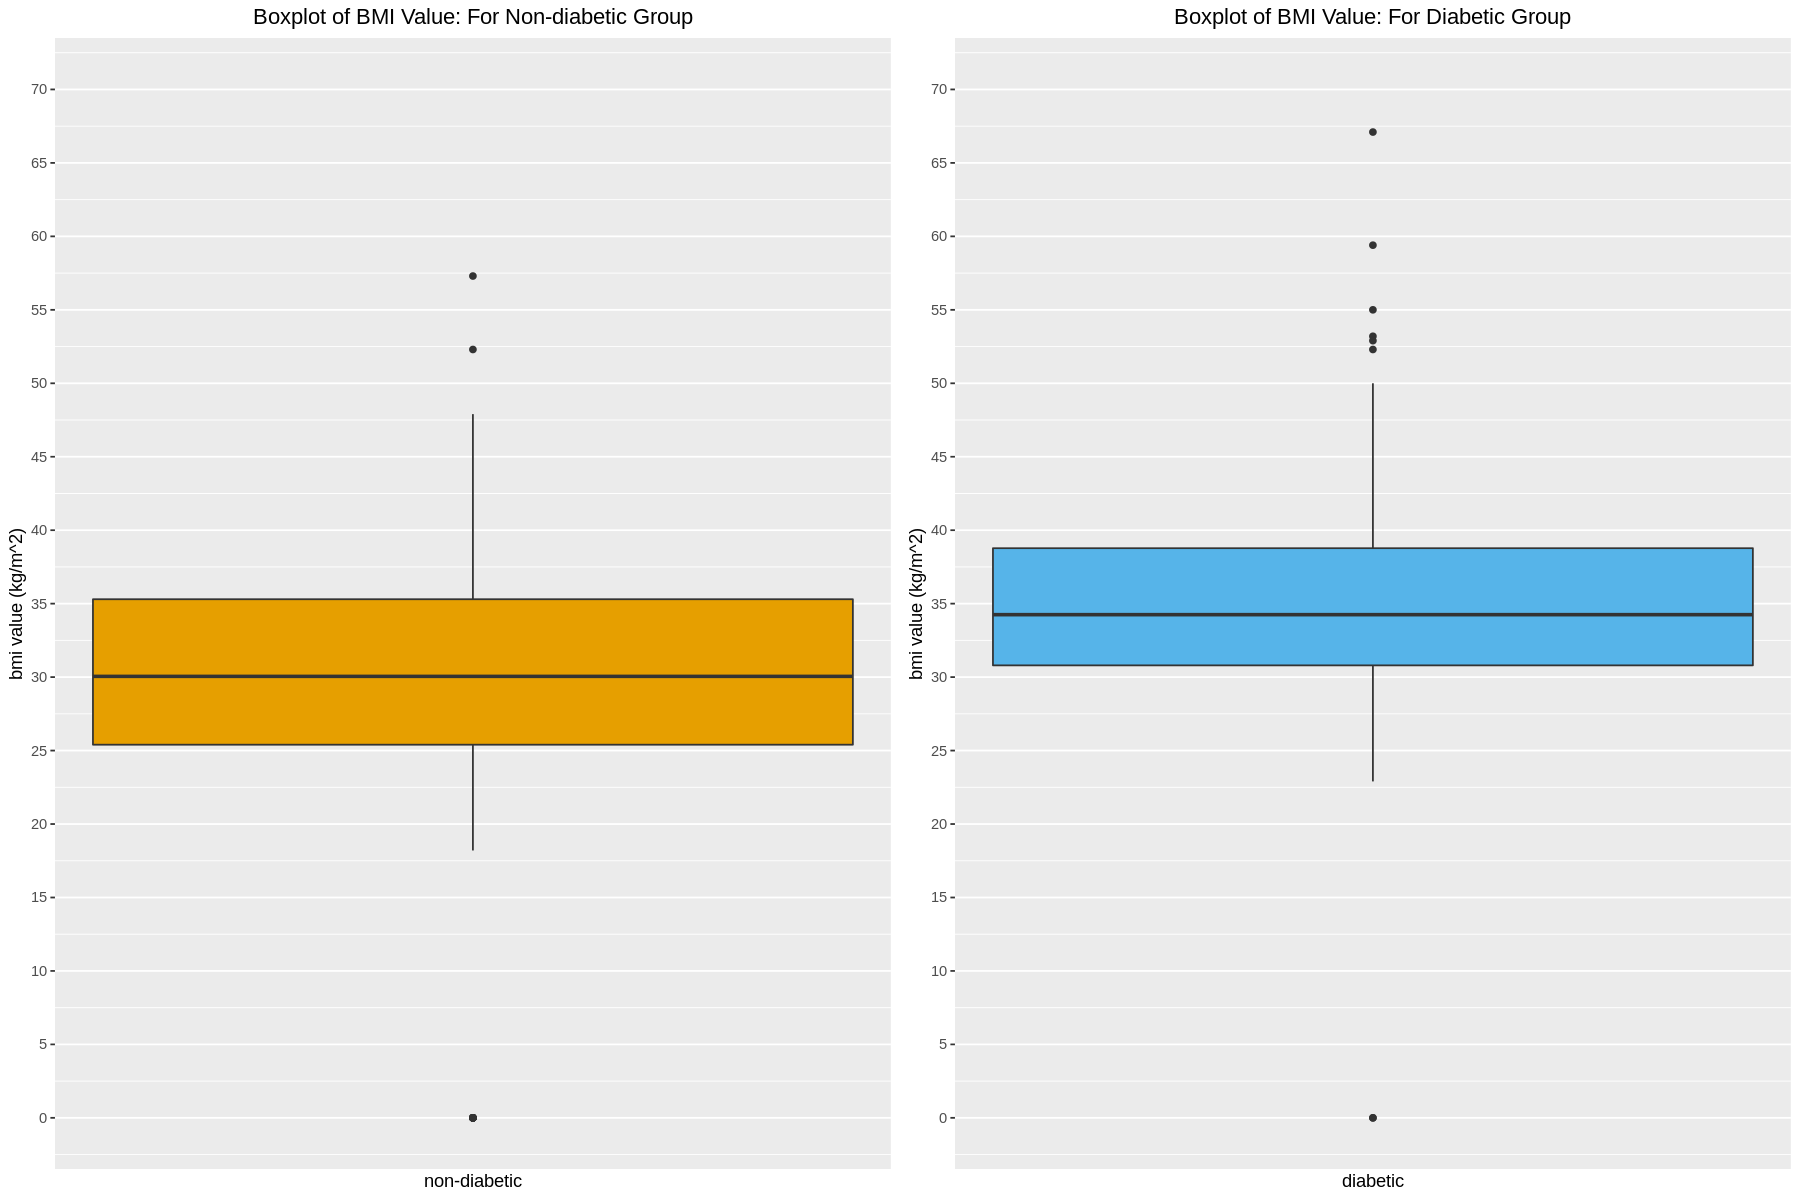

In [23]:
# BOXPLOT

    ## FOR DIABETIC GROUP:
    boxplot_diabetic <- diabetic_group %>%
            ggplot(aes(y = bmi)) +
            geom_boxplot(fill = lightblue) +
            labs( y = "bmi value (kg/m^2)", x = 'diabetic', title = "Boxplot of BMI Value: For Diabetic Group") +
            scale_y_continuous(limits = c(0,70), breaks=seq(0,100, 5)) +
            scale_x_continuous(breaks=seq(-100,100, 200)) +
            theme(plot.title = element_text(hjust = .5))

    ## FOR NON-DIABETIC GROUP:
    boxplot_nondiabetic <- nondiabetic_group %>%
            ggplot(aes(y = bmi)) +
            geom_boxplot(fill = lightorange) +
            labs(y = "bmi value (kg/m^2)", x = 'non-diabetic', title = "Boxplot of BMI Value: For Non-diabetic Group") + 
            scale_y_continuous(limits = c(0,70), breaks=seq(0,100, 5)) +
            scale_x_continuous(breaks=seq(-100,100, 200)) +
            theme(plot.title = element_text(hjust = .5))


# BOXPLOT of BMI values 
plot_grid(boxplot_nondiabetic, boxplot_diabetic)

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


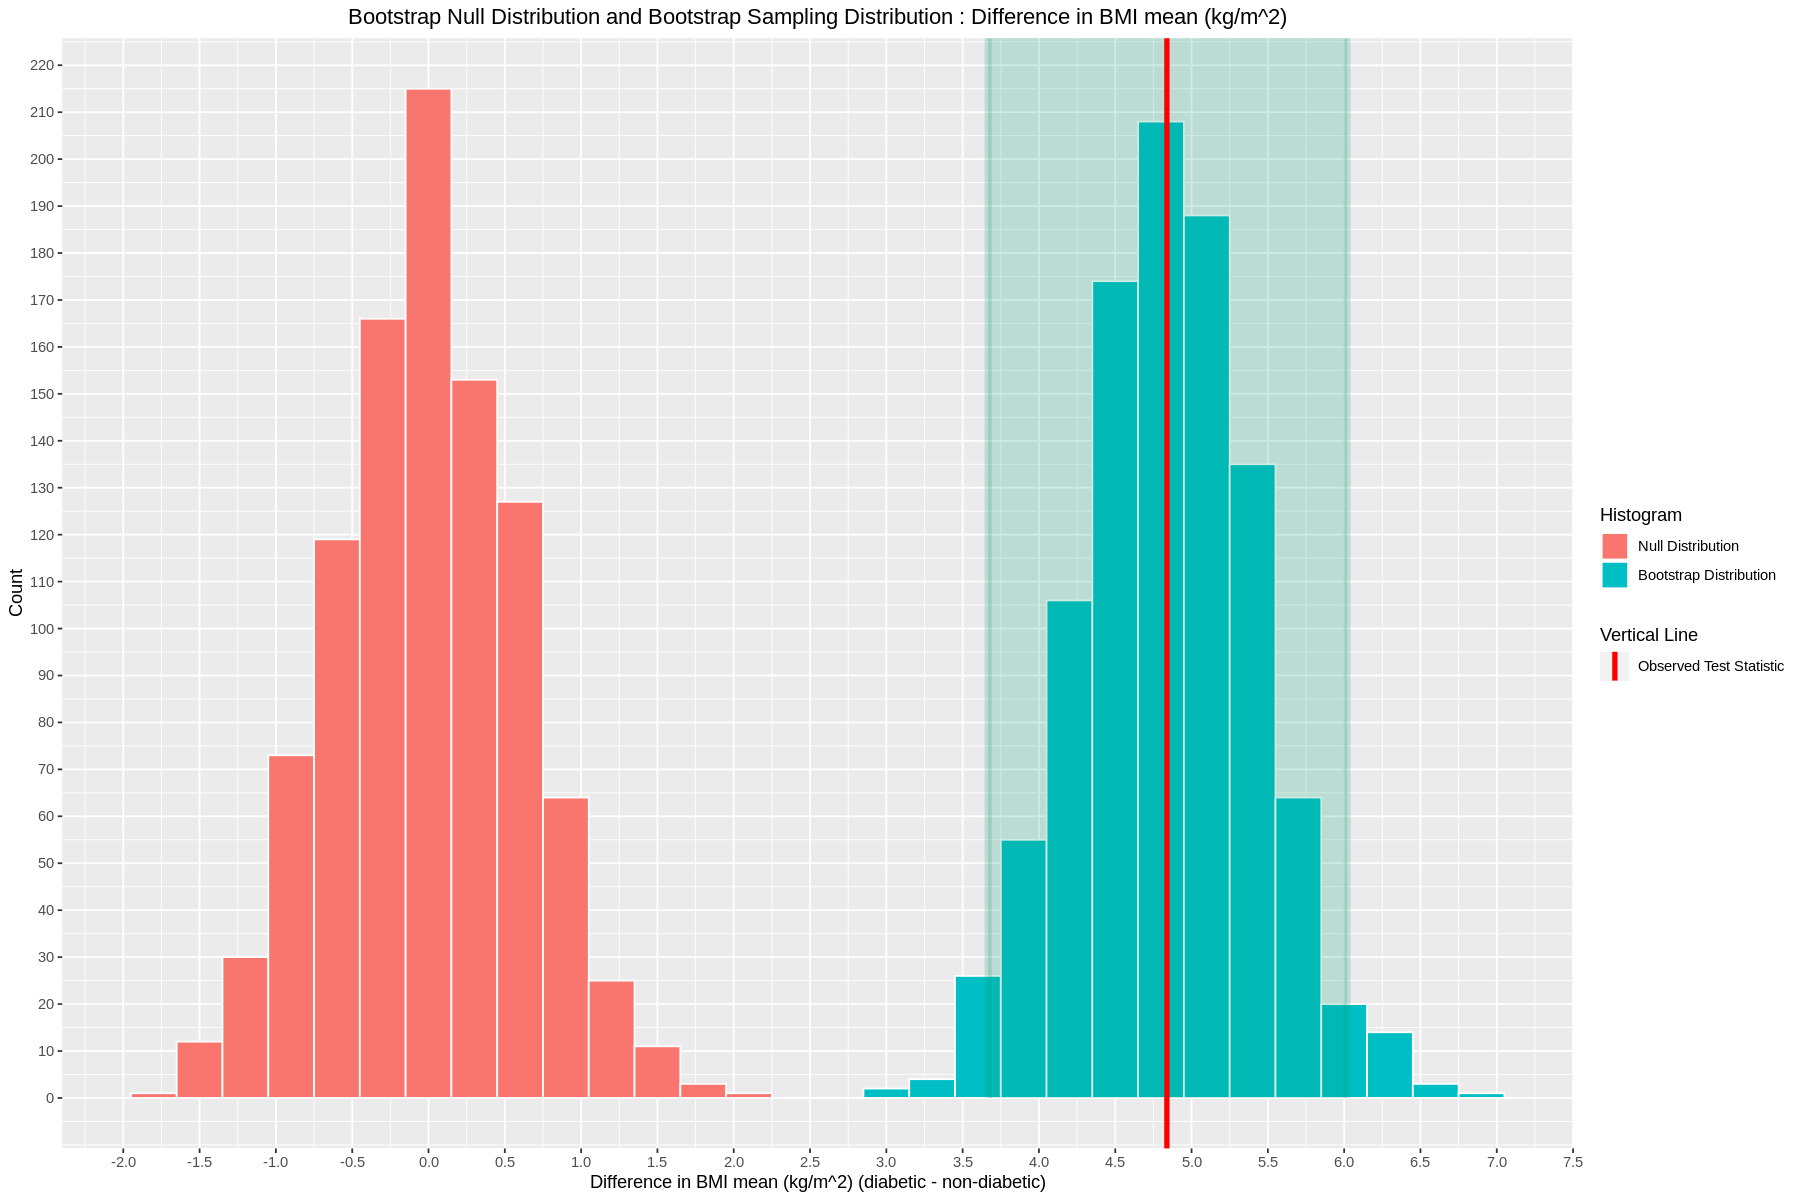

In [24]:
# BOOTSTRAPPING METHOD
set.seed(999)

# bootstrap sampling distribution vs null sampling distribution
boot_sample_dist <-
    diabetes %>%
    specify(formula = bmi ~ outcome) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE")) 

boot_null_dist <-
    diabetes %>%
    specify(formula = bmi ~ outcome) %>%
    hypothesize(null="independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE")) 

# observed test statistic
obs_test_stat <- difference_in_mean_pop

# p value
null_p_value <- 
    boot_null_dist %>% 
    get_p_value(obs_stat = obs_test_stat, direction = "right")


# confidence interval : bootstrap sampling distribution
boot_sample_ci <-
    boot_sample_dist %>%
    summarize(ci_lower = quantile(stat, 0.025),
              ci_upper = quantile(stat, 0.975))

# Visualization
boot_null_dist_plot <- 
    ggplot() +
    labs(x = 'Difference in BMI mean (kg/m^2) (diabetic - non-diabetic)', y = 'Count', title = 'Bootstrap Null Distribution and Bootstrap Sampling Distribution : Difference in BMI mean (kg/m^2)') +
    scale_fill_discrete(name = "Histogram", labels = c('Null Distribution','Bootstrap Distribution')) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_histogram(aes(x = boot_sample_dist$stat, fill = 'boot_sample_dist$stat'), color = 'white', binwidth = 0.3 ) +
    geom_histogram(aes(x = boot_null_dist$stat, fill = 'boot_null_dist$stat'), color = 'white', binwidth = 0.3) +
    shade_confidence_interval(boot_sample_ci, alpha = 0.2, color = lightgreen, fill = lightgreen) +
    geom_vline(aes(xintercept = obs_test_stat, color = 'red'), size = 1.5)  + 
    scale_color_manual(values = c('red' = 'red'), labels = c("Observed Test Statistic"), name = 'Vertical Line') +
    scale_x_continuous(breaks=seq(-3,8, 0.5)) +
    scale_y_continuous(breaks=seq(0,250, 10)) 


boot_null_dist_plot

In [25]:
null_p_value

p_value
<dbl>
0


In [26]:
boot_sample_ci

ci_lower,ci_upper
<dbl>,<dbl>
3.666813,6.018695


In [46]:
# ASYMPTOTIC METHOD

set.seed(999)

asymptotic_method <-
broom::tidy(
t.test(x = diabetic_group,
       y = nondiabetic_group,
       alternative = "greater",
       conf.level = 0.95)) %>%
rename(obs.test.stat. = estimate,
       mean.diabetic = estimate1,
       mean.nondiabetic = estimate2)

asymptotic_method

obs.test.stat.,mean.diabetic,mean.nondiabetic,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
4.838337,35.14254,30.3042,8.619317,3.283119e-17,573.4725,3.913527,Inf,Welch Two Sample t-test,greater


In [50]:
asymptotic_ci <- tibble(
        lower_ci = (mean(diabetic_group$bmi) - mean(nondiabetic_group$bmi)) - qt(0.975, df = 797) * sqrt(var(diabetic_group$bmi)/nrow(diabetic_group) + var(nondiabetic_group$bmi)/nrow(nondiabetic_group)),
        upper_ci = (mean(diabetic_group$bmi) - mean(nondiabetic_group$bmi)) + qt(0.975, df = 797) * sqrt(var(diabetic_group$bmi)/nrow(diabetic_group) + var(nondiabetic_group$bmi)/nrow(nondiabetic_group)))
asymptotic_ci


lower_ci,upper_ci
<dbl>,<dbl>
3.736465,5.94021


In [57]:
asymptotic_moe <-
qt(0.975, df = 767) * sqrt(var(diabetic_group)/nrow(diabetic_group) + var(nondiabetic_group)/nrow(nondiabetic_group))
asymptotic_moe

,bmi
bmi,1.101938
